In [289]:
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
import pickle, os, glob, sys, matplotlib
from itertools import accumulate
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, wilcoxon, norm
import numpy as np
from scipy.special import digamma, betainc

In [290]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

def exceedance_proba(alpha, Nsamp=1e6):

    # Compute exceedance probabilities for a Dirichlet distribution
    # FORMAT xp = spm_dirichlet_exceedance(alpha,Nsamp)
    # 
    # Input:
    # alpha     - Dirichlet parameters
    # Nsamp     - number of samples used to compute xp [default = 1e6]
    # 
    # Output:
    # xp        - exceedance probability
    #__________________________________________________________________________
    #
    # This function computes exceedance probabilities, i.e. for any given model
    # k1, the probability that it is more likely than any other model k2.  
    # More formally, for k1=1..Nk and for all k2~=k1, it returns p(x_k1>x_k2) 
    # given that p(x)=dirichlet(alpha).
    # 
    # Refs:
    # Stephan KE, Penny WD, Daunizeau J, Moran RJ, Friston KJ
    # Bayesian Model Selection for Group Studies. NeuroImage (in press)
    #__________________________________________________________________________
    # charles.findling
    # this is a translation from matlab to code. We tried to keep the structure
    # the closest possible to the original script

    Nk = len(alpha)
    xp = np.zeros(Nk)

    for i in range(Nsamp):
        # Sample from univariate gamma densities then normalise
        # (see Dirichlet entry in Wikipedia or Ferguson (1973) Ann. Stat. 1,
        # 209-230)
        #----------------------------------------------------------------------

        r = np.zeros(Nk)
        for k in range(Nk):
            r[k] = np.random.gamma(alpha[k], 1)

        sr = np.sum(r)
        for k in range(Nk):
            r[k] = r[k]/sr

        # Exceedance probabilities:
        # For any given model k1, compute the probability that it is more
        # likely than any other model k2~=k1
        # ----------------------------------------------------------------------
        xp[np.argmax(r)] += 1

    return xp/sum(xp)

def BMS_dirichlet(*args):
    # Bayesian model selection for group studies
    # FORMAT [alpha, exp_r, xp] = spm_BMS (lme, Nsamp, ecp, alpha0)
    # 
    # INPUT:
    # lme      - array of log model evidences 
    #              rows: subjects
    #              columns: models (1..Nk)
    # Nsamp    - number of samples used to compute exceedance probabilities
    #            (default: 1e6)
    # do_plot  - 1 to plot p(r|y)
    # sampling - use sampling to compute exact alpha
    # ecp      - 1 to compute exceedance probability
    # alpha0   - [1 x Nk] vector of prior model counts
    # 
    # OUTPUT:
    # alpha   - vector of model probabilities
    # exp_r   - expectation of the posterior p(r|y)
    # xp      - exceedance probabilities
    # 
    # REFERENCE:
    # Stephan KE, Penny WD, Daunizeau J, Moran RJ, Friston KJ (2009)
    # Bayesian Model Selection for Group Studies. NeuroImage 46:1004-1017
    #__________________________________________________________________________
    # charles.findling
    # this is a translation from matlab to code. We tried to keep the structure
    # the closest possible to the original script

    if len(args) < 1:
        return ValueError('Invalid number of arguments') 

    max_val    = np.finfo('float').max
    lme        = args[0]
    Ni, Nk     = lme.shape
    c          = 1.
    cc         = 1e-3
    log_u      = np.zeros([Ni, Nk])
    u          = np.zeros([Ni, Nk])
    g          = np.zeros([Ni, Nk])
    beta       = np.zeros(Nk)
    prev_alpha = np.zeros(Nk)
    exp_r      = np.zeros(Nk)
    xp         = np.zeros(Nk)

    if len(args) < 2:
        N_samp = int(1e6)
    else:
        N_samp = int(args[1])
    if len(args) < 3:
        ecp = 1
    else:
        ecp = args[2]

    # prior observations
    # --------------------------------------------------------------------
    if len(args) < 4:
        alpha0 = np.ones(Nk)
    else:
        alpha0 = args[3]
    alpha = np.array(alpha0)


    # iterative VB estimation
    # ---------------------------------------------------------------------

    while c > cc:

        # compute posterior belief g(i,k)=q(m_i=k|y_i) that model k generated
        # the data for the i-th subject
        for i in range(Ni):
            for k in range(Nk):
                # integrate out prior probabilities of models (in log space)
                log_u[i, k] = lme[i,k] + digamma(alpha[k]) - digamma(np.sum(alpha))

            # prevent overflow
            log_u[i, :] = log_u[i, :] - np.max(log_u[i,:])

            # prevent numerical problems for badly scaled posteriors
            for k in range(Nk):
                log_u[i,k] = np.sign(log_u[i,k]) * np.minimum(max_val, np.abs(log_u[i,k]))

            # exponentiate (to get back to non-log representation)
            u[i,:] = np.exp(log_u[i,:])

            # normalisation: sum across all models for i-th subject
            u_i    = np.sum(u[i,:])
            g[i,:] = u[i,:]/u_i

        # expected number of subjects whose data we believe to have been 
        # generated by model k
        for k in range(Nk):
            beta[k] = np.sum(g[:,k])

        # update alpha
        prev_alpha[:] = alpha
        for k in range(Nk):
            alpha[k] = alpha0[k] + beta[k]

        # convergence?
        c = np.sum(np.abs(alpha - prev_alpha))

    # Compute expectation of the posterior p(r|y)
    # --------------------------------------------------------------------------
    exp_r[:] = alpha/np.sum(alpha) 

    # Compute exceedance probabilities p(r_i>r_j)
    # --------------------------------------------------------------------------

    if ecp:
        if Nk == 2:
            # comparison of 2 models
            xp[0] = betainc(alpha[1], alpha[0], .5)
            xp[1] = betainc(alpha[0], alpha[1], .5)
        else:
            # comparison of >2 models: use sampling approach
            xp = exceedance_proba(alpha, N_samp)

    return [alpha, exp_r, xp]

hide_toggle()

### Importing behavioral data
We import here the behavior of N=24 subjects which performed 2 sessions of a restless bandit task with 100 trials
The cell outputs the actions, the observed rewards and the correct answer. Each of these arrays are tensors of dimension N_subjects x N_sessions x N_trials

In [291]:
nb_subjects, nb_sessions, nb_trials = 24, 2, 100
actions, obs_rewards, correct_answer = np.zeros([nb_subjects, nb_sessions, nb_trials]), \
                                                    np.zeros([nb_subjects, nb_sessions, nb_trials]), \
                                                        np.zeros([nb_subjects, nb_sessions, nb_trials])
for i_sub in range(nb_subjects):
    for i_sess in range(nb_sessions):
        f = pickle.load(open('data/td_volnoise_subj_{}_session_{}.pkl'.format(i_sub + 1, i_sess), 'rb'))
        actions[i_sub, i_sess] = f['a_chosen']
        obs_rewards[i_sub, i_sess] = f['reward']
        correct_answer[i_sub, i_sess] = f['correct']        

### Q1: Plotting subject performances
TODO: What is the mean and standard deviation of human performances (nb of times subjects chose the highest-rewarding arm)?  <br>
TODO: Does the performances increase between session 1 and session 2 (use wilcoxon for statistics)? <br>
TODO: Do performance across session 1 and 2 correlate (use pearsonr method for statistics)? <br>
TODO: Plot the performance over session 1 as a function of the performance over session 2 with plt.scatter

mean performance is 0.55. Standard deviation is 0.0
between session difference test: WilcoxonResult(statistic=131.0, pvalue=0.6033114194869995)
between session correlation test: (0.20484388886871466, 0.33696037930163847)


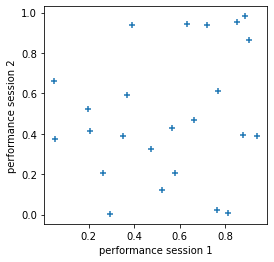

In [392]:
# mean and standard deviation
performances = np.random.rand() # takeout # write here
mean_perf, std_perf = np.mean(performances), np.std(performances)
print('mean performance is {}. Standard deviation is {}'.format(np.round(mean_perf, 2), np.round(std_perf, 2)))
# performance between sessions
performances_session1 = np.random.rand(nb_subjects) # takeout # write here
performances_session2 = np.random.rand(nb_subjects) # takeout # write here
print('between session difference test: {}'.format(wilcoxon(performances_session1, performances_session2)))
# between session correlation
print('between session correlation test: {}'.format(pearsonr(performances_session1, performances_session2)))
# plot
plt.figure(figsize=(4, 4))
plt.scatter(performances_session1, performances_session2, marker='+')
plt.xlabel('performance session 1')
plt.ylabel('performance session 2')
hide_toggle()

### Definition of model likelihoods functions

In [367]:
''' 
return the loglikelihood for the model 1 (counting model) which assumes that humans
do not assume changes in the environment
This model has one parameter: a softmax parameter
beta is a number
args is the list = [actions, rewards]
'''
def negLogLikelihood_m1(beta, *args):
    if len(args) != 2: assert(False), 'InputError'
    actions, rewards = args
    if len(actions.shape) == 1:
        actions = np.expand_dims(actions, 0)
    if len(rewards.shape) == 1:
        rewards = np.expand_dims(rewards, 0)
    negloglkd = 0
    for i in range(len(rewards)):
        countA = np.cumsum((actions[i] == 0) * rewards[i] + (actions[i] == 1) * (1 - rewards[i]))
        countB = np.cumsum((actions[i] == 1) * rewards[i] + (actions[i] == 0) * (1 - rewards[i]))
        counts = np.vstack((countA, countB))
        counts_chosen = counts[(actions[i]==1)*1, np.arange(len(actions[i]))]
        counts_unchosen = counts[(actions[i]==0)*1, np.arange(len(actions[i]))]        
        negloglkd += -np.sum(beta * counts_chosen - np.logaddexp(beta * counts_chosen, beta * counts_unchosen))
    return negloglkd

''' 
return the loglikelihood for the model 2 (drifting model) which assumes that humans
assume changes in the environment.
This model has two parameters: a softmax parameter and a learning rate
parameters is a array of two numbers = [learning_rate, beta]
args is the list = [actions, rewards]
'''
def negLogLikelihood_m2(parameters, *args):
    if len(args) != 2: assert(False), 'InputError'
    actions, rewards = args
    alpha, beta = parameters
    if len(actions.shape) == 1:
        actions = np.expand_dims(actions, 0)
    if len(rewards.shape) == 1:
        rewards = np.expand_dims(rewards, 0)
    negloglkd = 0    
    for i in range(len(rewards)):
        correctA = np.concatenate((np.array([0.5]), (actions[i] == 0) * rewards[i] + (actions[i] == 1) * (1 - rewards[i])))
        correctB = np.concatenate((np.array([0.5]), (actions[i] == 1) * rewards[i] + (actions[i] == 0) * (1 - rewards[i])))
        pA = np.array(list(accumulate(correctA, lambda x, y: (1 - alpha) * x + alpha * y)))[:-1]
        pB = np.array(list(accumulate(correctB, lambda x, y: (1 - alpha) * x + alpha * y)))[:-1]
        probabilities = np.vstack((pA, pB))
        prob_chosen = probabilities[(actions[i]==1)*1, np.arange(len(actions[i]))]
        prob_unchosen = probabilities[(actions[i]==0)*1, np.arange(len(actions[i]))]
        negloglkd += -np.sum(beta * prob_chosen - np.logaddexp(beta * prob_chosen, beta * prob_unchosen))
    return negloglkd
hide_toggle()

## FREQUENTIST APPROACH

### How to obtain the maximum likelihood for one example subject and session
Uses 'L-BFGS-B' which computes an approximate hessian from the scipy.optimize library - corresponds to the fmincon in MATLAB

In [395]:
i_subj_example, i_session_example = 2, 0
# for model m1
act, obs_r = actions[i_subj_example, i_session_example], \
                    obs_rewards[i_subj_example, i_session_example] # get subjects action and reward
initial_points, res = [0.1, 0.2, 0.4, 0.8, 0.], None
for init in initial_points: # try multiple initializations
    candidate_res = minimize(negLogLikelihood_m1, [init], args=(act, obs_r), method='L-BFGS-B', tol=1e-6)
    if res is None or candidate_res.fun < res.fun:
        res = candidate_res # replace old result if it is None (first step) or if the candidate result is better
beta_example_1 = res.x
print('Model M1 for example subj {}, and session {}'.format(i_subj_example, i_session_example))
print('ML parameters (softmax) are : {}'.format(res.x))
print('logML is : {}'.format(-res.fun))
print('trial-wise ML is : {}'.format(np.exp(-res.fun/nb_trials)))
print('')
# for model m2
act, obs_r = actions[i_subj_example, i_session_example], \
                    obs_rewards[i_subj_example, i_session_example] # get subjects action and reward
initial_points, res = [[0.1, 1], [0.2, 4], [0.4, 3], [0.8, 10]], None
for init in initial_points: # try multiple initializations
    candidate_res = minimize(negLogLikelihood_m2, init, args=(act, obs_r), method='L-BFGS-B', tol=1e-6)
    if res is None or candidate_res.fun < res.fun:
        res = candidate_res # replace old result if it is None (first step) or if the candidate result is better
alpha_example_2, beta_example_2 = res.x
print('Model M2 for example subj {}, and session {}'.format(i_subj_example, i_session_example))
print('ML parameters (learning rate and softmax) are : {}'.format(res.x))
print('logML is : {}'.format(-res.fun))
print('trial-wise ML is : {}'.format(np.exp(-res.fun/nb_trials)))

hide_toggle()

Model M1 for example subj 2, and session 0
ML parameters (softmax) are : [0.14604618]
logML is : -64.7542978732786
trial-wise ML is : 0.5233300314113893

Model M2 for example subj 2, and session 0
ML parameters (learning rate and softmax) are : [0.39348431 5.6727822 ]
logML is : -25.778120415660723
trial-wise ML is : 0.77276429122638


### Q2: Obtain the maximum likelihood for all subjects (see previous cell for example subject)
TODO: Compute the logML, the trial-wise ML, the ML parameters of these two models for all N=24 subjects on session 0. <br>
TODO: Plot the distribution over learning rates and softmax parameters.

Model M1
The average trial-wise likelihood (mean and std) for m1: 0.0 ± 0.0
The average parameters (mean and std) for m1: 0.0 ± 0.0

Model M2
The average trial-wise likelihood (mean and std) for m2: 0.0 ± 0.0
The average parameters (mean and std) for m2: 0.0 ± 0.0


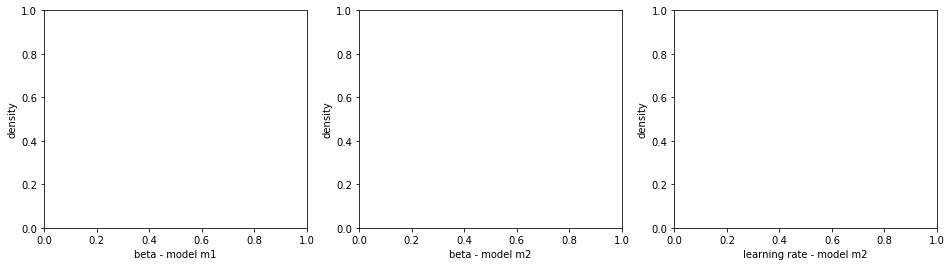

In [369]:
logML, trialwiseML = np.zeros([nb_subjects, 2]), np.zeros([nb_subjects, 2]) # second dimension is for m1 and m2
ML_parameters_m1, ML_parameters_m2 = np.zeros([nb_subjects]), np.zeros([nb_subjects, 2])
for i_subj in range(nb_subjects):
    ... # write here
print('Model M1')
print('The average trial-wise likelihood (mean and std) for m1: {} ± {}'.format(np.mean(trialwiseML[:, 0]), np.std(trialwiseML[:, 0])))
print('The average parameters (mean and std) for m1: {} ± {}'.format(np.mean(ML_parameters_m1, axis=0), np.std(ML_parameters_m1, axis=0)))
print('')
print('Model M2')
print('The average trial-wise likelihood (mean and std) for m2: {} ± {}'.format(np.mean(trialwiseML[:, 1]), np.std(trialwiseML[:, 1])))
print('The average parameters (mean and std) for m2: {} ± {}'.format(np.mean(ML_parameters_m1, axis=0), np.std(ML_parameters_m1, axis=0)))

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
# write here
plt.ylabel('density')
plt.xlabel('beta - model m1')
plt.subplot(1, 3, 2)
# write here
plt.ylabel('density')
plt.xlabel('beta - model m2')
plt.subplot(1, 3, 3)
# write here
plt.ylabel('density')
plt.xlabel('learning rate - model m2')
hide_toggle()

### How to obtain the loglikelihood of both models for the one example subject on the held-out session

In [403]:
i_session_example = 1
act, obs_r = actions[i_subj_example, i_session_example], obs_rewards[i_subj_example, i_session_example]
loglkd_m1 = -negLogLikelihood_m1(beta_example_1, act, obs_r)
loglkd_m2 = -negLogLikelihood_m2([alpha_example_2, beta_example_2], act, obs_r)
print('model M1 for example subj {}'.format(i_session_example))
print('LogLikelihood on held-out session {} : {}'.format(i_session_example, loglkd_m1))
print('Trial-wise likelihood on held-out session {}: {}'.format(i_session_example, np.exp(loglkd_m1/nb_trials)))
print('')
print('model M2 for example subj {}'.format(i_session_example))
print('LogLikelihood on held-out session {}: {}'.format(i_session_example, loglkd_m2))
print('Trial-wise likelihood on held-out session {}: {}'.format(i_session_example, np.exp(loglkd_m2/nb_trials)))
hide_toggle()

model M1 for example subj 1
LogLikelihood on held-out session 1 : -98.9245883553368
Trial-wise likelihood on held-out session 1: 0.3718570087987689

model M2 for example subj 1
LogLikelihood on held-out session 1: -63.11884098026329
Trial-wise likelihood on held-out session 1: 0.5319592396352942


### Q3: Obtain the loglikehoods on held-out sessions for all subjects (see previous cell for example subject)
TODO:  Does one model better explain the behavior than the other. If yes, which one? use wilcoxon to conclude on statistics <br>
TODO: Across subjects, is the logML on the held-in session better than on the held-out session (use wilcoxon)? is there overfitting?

In [371]:
heldout_logML = np.zeros([nb_subjects, 2]) + np.random.rand() # takeout
for i_subj in range(nb_subjects):
    ... # write here
print('difference of logML between models: {}'.format(wilcoxon(heldout_logML[:, 0], heldout_logML[:, 1])))    
print('The winning model is ...') # write here
print('M1: difference of logML between held-in and held-out sessions: {}'.format(wilcoxon(logML[:, 0], heldout_logML[:, 0])))
print('M2: difference of logML between held-in and held-out sessions: {}'.format(wilcoxon(logML[:, 1], heldout_logML[:, 1])))
hide_toggle()

The winning model is ...
M1: difference of logML between held-in and held-out sessions: WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07)
M2: difference of logML between held-in and held-out sessions: WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07)


### Definition of simulation functions

In [372]:
''' 
return the simulations for model 1
This model has one parameter: a softmax parameter
'''
def simulation_m1(beta, *args):
    if len(args) != 2: assert(False), 'InputError'
    actions, rewards = args
    if len(actions.shape) == 1:
        actions = np.expand_dims(actions, 0)
    if len(rewards.shape) == 1:
        rewards = np.expand_dims(rewards, 0)
    simulated_actions = []
    for i in range(len(rewards)):
        countA = np.cumsum((actions[i] == 0) * rewards[i] + (actions[i] == 1) * (1 - rewards[i]))
        countB = np.cumsum((actions[i] == 1) * rewards[i] + (actions[i] == 0) * (1 - rewards[i]))
        pA_dec     = np.exp(beta * countA)/(np.exp(beta * countA) + np.exp(beta * countB))
        actions_session = (np.random.rand(len(countA)) > pA_dec)
        simulated_actions.append(actions_session)
    return np.array(simulated_actions)

''' 
return the simulations for model 2
This model has two parameters: a softmax parameter and a learning rate
'''
def simulation_m2(parameters, *args):
    if len(args) != 2: assert(False), 'InputError'
    actions, rewards = args
    alpha, beta = parameters
    if len(actions.shape) == 1:
        actions = np.expand_dims(actions, 0)
    if len(rewards.shape) == 1:
        rewards = np.expand_dims(rewards, 0)    
    simulated_actions = []
    for i in range(len(rewards)):
        correctA = np.concatenate((np.array([0.5]), (actions[i] == 0) * rewards[i] + (actions[i] == 1) * (1 - rewards[i])))
        correctB = np.concatenate((np.array([0.5]), (actions[i] == 1) * rewards[i] + (actions[i] == 0) * (1 - rewards[i])))
        pA = np.array(list(accumulate(correctA, lambda x, y: (1 - alpha) * x + alpha * y)))[:-1]
        pB = np.array(list(accumulate(correctB, lambda x, y: (1 - alpha) * x + alpha * y)))[:-1]
        pA_dec = np.exp(beta * pA)/(np.exp(beta * pA) + np.exp(beta * pB))
        actions_session = (np.random.rand(len(pA)) > pA_dec)
        simulated_actions.append(actions_session)
    return np.array(simulated_actions)
hide_toggle()

### How to simulate and plot for example subject on held-out session

model free performance metric for subject 0
performances is 0.57
performances of simulations of m1 is 0.8608
performances of simulations of m2 is 0.6058


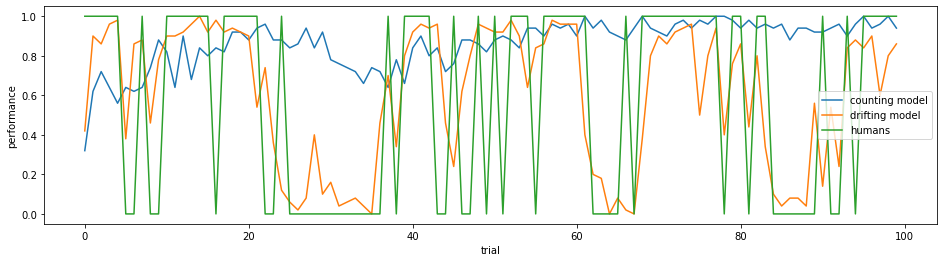

In [391]:
i_session_example, nb_sim = 1, 50
simulated_actions_m1 = np.zeros([nb_sim, nb_trials])
simulated_actions_m2 = np.zeros([nb_sim, nb_trials])
for i in range(nb_sim):
    act, obs_r = actions[i_subj_example, i_session_example], obs_rewards[i_subj_example, i_session_example]
    simulated_actions_m1[i] = simulation_m1(beta_example_1, act, obs_r)
    simulated_actions_m2[i] = simulation_m2([alpha_example_2, beta_example_2], act, obs_r)

performance_subject = (actions[i_subj_example, i_session_example] == correct[i_subj_example, i_session_example]).mean()
performances_m1 = (simulated_actions_m1==correct[i_subj_example, i_session_example]).mean()
performances_m2 = (simulated_actions_m2==correct[i_subj_example, i_session_example]).mean()

print('model free performance metric for subject {}'.format(i_subj_example))
print('performances is {}'.format(performance_subject))
print('performances of simulations of m1 is {}'.format(performances_m1))
print('performances of simulations of m2 is {}'.format(performances_m2))

performances_m1 = (simulated_actions_m1==correct[i_subj_example, i_session_example]).mean(axis=0)
performances_m2 = (simulated_actions_m2==correct[i_subj_example, i_session_example]).mean(axis=0)
performances_subject = (actions[i_subj_example, i_session_example] == correct[i_subj_example, i_session_example])
plt.figure(figsize=(16,4))
plt.plot(performances_m1, label='counting model')
plt.plot(performances_m2, label='drifting model')
plt.plot(performances_subject, label='humans')
plt.xlabel('trial')
plt.ylabel('performance')
plt.gca().legend()
hide_toggle()

### Q4: Simulate the models and plot model-free metrics
TODO: for each subject, simulate the two models N=50 times given the ML parameters <br>
TODO: compare the average performance of subjects with the averaged performances of the simulations. Do they differ? perform wilcoxon for statistics <br>
TODO: Plot the performance as a function of the trial id for the averaged simulations and for the averaged human subjects. Can we dissociate the models based on this second metric?

In [374]:
nb_sim = 50
simulated_actions_m1 = np.zeros([nb_sim, nb_subjects, nb_trials])
simulated_actions_m2 = np.zeros([nb_sim, nb_subjects, nb_trials])
for i_sub in range(nb_subjects):
    ...# write here

# write here for plot
hide_toggle()

## BAYESIAN APPROACH

### How to compute BIC and AIC for the one example subject
This requires computing the maximum likelihood over both sessions (no cross-validation is necessary as the BIC and AIC penalize for the number of parameters)

In [396]:
i_subj_example = 0

# model m1
act, obs_r = actions[i_subj_example, i_session_example], \
                    obs_rewards[i_subj_example, i_session_example] # get subjects action and reward
initial_points, res = [0.1, 0.2, 0.4, 0.8, 0.], None
for init in initial_points: # try multiple initializations
    candidate_res = minimize(negLogLikelihood_m1, [init], args=(act, obs_r), method='L-BFGS-B', tol=1e-6)
    if res is None or candidate_res.fun < res.fun:
        res = candidate_res # replace old result if it is None (first step) or if the candidate result is better
aic_1, bic_1 = -res.fun - 1, -res.fun - 1 * np.log(nb_sessions * nb_trials)/2.
print('Model M1 for example subj {}'.format(i_subj_example))
print('BIC is : {}'.format(bic_1))
print('AIC is : {}'.format(aic_1))
print('')
# model m2
act, obs_r = actions[i_subj_example, i_session_example], \
                    obs_rewards[i_subj_example, i_session_example] # get subjects action and reward
initial_points, res = [[0.1, 1], [0.2, 4], [0.4, 3], [0.8, 10]], None
for init in initial_points: # try multiple initializations
    candidate_res = minimize(negLogLikelihood_m2, init, args=(act, obs_r), method='L-BFGS-B', tol=1e-6)
    if res is None or candidate_res.fun < res.fun:
        res = candidate_res # replace old result if it is None (first step) or if the candidate result is better
alpha_example_2, beta_example_2 = res.x
aic_2, bic_2 = -res.fun - 1, -res.fun - 1 * np.log(nb_sessions * nb_trials)/2.
print('Model M2 for example subj {}'.format(i_subj_example))
print('BIC is : {}'.format(bic_2))
print('AIC is : {}'.format(aic_2))

hide_toggle()

Model M1 for example subj 0
BIC is : -70.63428742622803
AIC is : -68.985128742954

Model M2 for example subj 0
BIC is : -26.586946737683082
AIC is : -24.937788054409065


### Q5: Obtain the BIC and AIC for all subjects (see previous cell for example subject)
TODO: obtain the BICs and AIC <br>
TODO: fixed-effect analysis - compute the Bayes factor in favor of each model <br>
TODO: random-effect analysis - Bayesian model selection <br>
TODO: do fixed-effect and random-effect analysis agree? do they agree with the frequentist CV method?

The winning model in fixed-effect is ... with a BF = ...
The winning model in random-effect is ... with an exceendance probability = ...


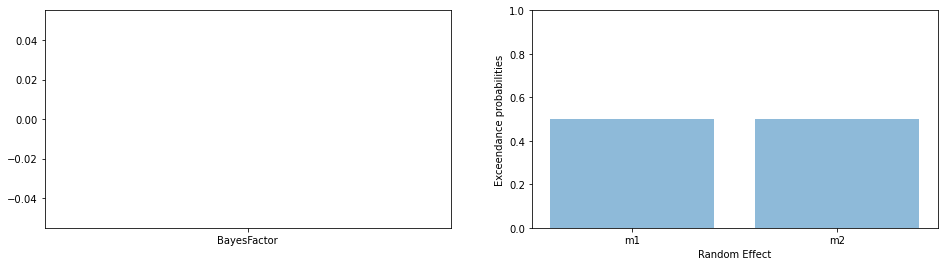

In [402]:
AICs, BICs = np.zeros([nb_subjects, 2]), np.zeros([nb_subjects, 2]) # second dimension is for m1 and m2
for i_subj in range(nb_subjects):
    ...

bayesFactor = np.sum(np.diff(BICs)) # for fixed-effect analysis
# for random-effect analysis returns counts, model frequencies and exceedance probabilities
alpha, expr, xp = BMS_dirichlet(BICs)
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1), bayesFactor)
plt.xticks([0,], ['BayesFactor',])
plt.subplot(1, 2, 2)
plt.bar(range(2), xp, alpha=0.5)
plt.gca().set_ylim(0, 1)
plt.xticks([0, 1], ['m1', 'm2'])
plt.ylabel('Exceendance probabilities')
plt.xlabel('Random Effect')

print('The winning model in fixed-effect is {} with a BF = {}'.format('...', '...'))
print('The winning model in random-effect is {} with an exceendance probability = {}'.format('...', '...'))
hide_toggle()

### How to obtain the posterior distribution with Metropolis-Hasting for the example subject

Mean of posterior distribution for example subject 0 is 0.029
Standard deviation of posterior distribution for example subject 0 is 0.011


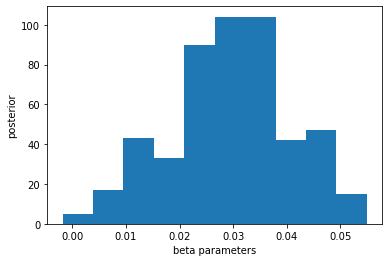

In [398]:
def metropolis_hasting(get_loglkd, nb_samples=1000):
    samples = np.zeros(nb_samples)
    for i in range(1, nb_samples):
        candidate = np.random.normal(samples[i-1], scale=0.05)
        logalpha = get_loglkd(candidate) - get_loglkd(samples[i-1]) + norm.logpdf(samples[i-1]) - norm.logpdf(candidate)
        if np.log(np.random.rand()) < logalpha:
            samples[i] = candidate
        else:
            samples[i] = samples[i-1]
    return samples

get_loglkd = lambda x: -negLogLikelihood_m1(x, actions[i_subj_example], obs_rewards[i_subj_example])
posterior_samples = metropolis_hasting(get_loglkd)
posterior_samples = posterior_samples[-int(len(posterior_samples)/2):] # take out burn-in period

plt.figure()
plt.hist(posterior_samples)
plt.ylabel('posterior')
plt.xlabel('beta parameters')
print('Mean of posterior distribution for example subject {} is {}'.format(i_subj_example, np.round(np.mean(posterior_samples), 3)))
print('Standard deviation of posterior distribution for example subject {} is {}'.format(i_subj_example, np.round(np.std(posterior_samples), 3)))
hide_toggle()

### Q6: Obtain the posterior distribution
TODO: for model m1, computer the posterior distribution with M-H for each subject. How peaked are the posterior distribution? Do the standard deviations of the posteriors correlates with the AIC across subjects?

In [399]:
nb_samples        = 1000
posterior_samples = np.zeros([nb_subjects, nb_samples])
for i_subj in range(nb_subjects):
    ...

### Q7: Perform model recovery for BIC
TODO: simulate each model N=50 times with the subjects parameters <br>
TODO: fit m1 and m2 to these models through BIC <br>
TODO: perform random effect analysis to quantify how well each model explains the simulated behavior <br>
TODO: plot confusion (model recovery) matrices with imshow